In [ ]:
import gymnasium as gym
import os
import numpy as np
from PIL import Image
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, VecTransposeImage
from stable_baselines3.common.atari_wrappers import MaxAndSkipEnv, NoopResetEnv
from stable_baselines3.common.monitor import Monitor
import ale_py
import matplotlib.pyplot as plt

In [8]:
gym.register_envs(ale_py)

In [9]:
class EpisodeRecorder:
    def __init__(self, save_dir="videos_Boxing_evaluation/"):
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)

    def save_video(self, images, episode, total_reward=None, is_best=False):
        if not images:
            return

        if is_best:
            path = f"{self.save_dir}best_episode_{episode}_reward_{total_reward:.2f}.gif"
        else:
            path = f"{self.save_dir}episode_{episode}.gif"
        images[0].save(path, save_all=True, append_images=images[1:], duration=100, loop=0)
        return path

In [10]:
def make_env(env_id, rank, seed=0):
    def _init():
        env = gym.make(env_id, render_mode="rgb_array")
        env = NoopResetEnv(env, noop_max=30)  #randomness to initial state
        env = MaxAndSkipEnv(env, skip=4)  #frame skipping
        env = Monitor(env)
        env.reset(seed=seed + rank)
        return env
    return _init

In [11]:
def evaluate_model(model, env, n_eval_episodes=100):
    rewards = []
    recorder = EpisodeRecorder(save_dir="./videos_Boxing_evaluation/")
    wins, losses, ties = 0, 0, 0
    best_reward = float('-inf')

    for episode in range(n_eval_episodes):

        obs = env.reset()

        done = False
        total_reward = 0
        images = []

        agent_score, enemy_score = 0, 0

        while not done:
            #get action
            action, _ = model.predict(obs, deterministic=True)

            step_result = env.step(action)

            obs, reward, done, info = step_result

            total_reward += reward

            #save frames for video
            frame = env.render()
            if frame is not None:
                frame = Image.fromarray(frame)
                images.append(frame)

            if reward > 0:
                agent_score += reward
            elif reward < 0:
                enemy_score -= reward

        total_reward = float(total_reward)

        if agent_score > enemy_score:
            wins += 1
        elif agent_score < enemy_score:
            losses += 1
        else:
            ties += 1

        if total_reward > best_reward:
            best_reward = total_reward
            best_episode = episode
            recorder.save_video(images, episode, total_reward, is_best=True)

        rewards.append(total_reward)
        if episode % 10 == 0:  #save every 10th episode
            recorder.save_video(images, episode, total_reward)

        print(f"Episode {episode} reward: {total_reward}")

    win_percentage = (wins / n_eval_episodes) * 100
    loss_percentage = (losses / n_eval_episodes) * 100
    tie_percentage = (ties / n_eval_episodes) * 100

    return np.mean(rewards), np.std(rewards), win_percentage, loss_percentage, tie_percentage, rewards, best_episode, best_reward


Loaded model from /content/models_boxing_ppo/best_model.zip


<ipython-input-11-4a3891661823>:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  total_reward = float(total_reward)


Episode 0 reward: 66.0
Episode 1 reward: 45.0
Episode 2 reward: 50.0
Episode 3 reward: 71.0
Episode 4 reward: 49.0
Episode 5 reward: 47.0
Episode 6 reward: 62.0
Episode 7 reward: 74.0
Episode 8 reward: 65.0
Episode 9 reward: 58.0
Episode 10 reward: 82.0
Episode 11 reward: 62.0
Episode 12 reward: 53.0
Episode 13 reward: 73.0
Episode 14 reward: 49.0
Episode 15 reward: 38.0
Episode 16 reward: 59.0
Episode 17 reward: 49.0
Episode 18 reward: 72.0
Episode 19 reward: 57.0
Episode 20 reward: 77.0
Episode 21 reward: 45.0
Episode 22 reward: 43.0
Episode 23 reward: 56.0
Episode 24 reward: 69.0
Episode 25 reward: 51.0
Episode 26 reward: 24.0
Episode 27 reward: 47.0
Episode 28 reward: 56.0
Episode 29 reward: 75.0
Episode 30 reward: 42.0
Episode 31 reward: 42.0
Episode 32 reward: 54.0
Episode 33 reward: 53.0
Episode 34 reward: 41.0
Episode 35 reward: 71.0
Episode 36 reward: 65.0
Episode 37 reward: 57.0
Episode 38 reward: 72.0
Episode 39 reward: 32.0
Episode 40 reward: 38.0
Episode 41 reward: 58.0
Ep

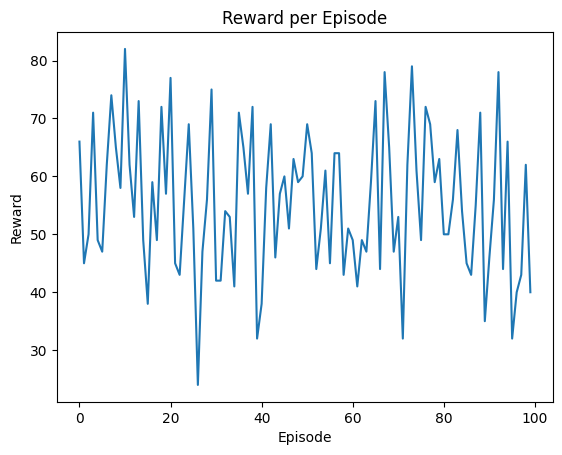

In [ ]:
env_id = "ALE/Boxing-v5"

#trained model
model_path = "./Solving-ALE-environments/Part 2 - Boxing/PPO/models_boxing_ppo/best_model.zip"
model = PPO.load(model_path)
print(f"Loaded model from {model_path}")

#eval environment
eval_env = DummyVecEnv([lambda: make_env(env_id, rank=0, seed=42)()])
eval_env = VecFrameStack(eval_env, n_stack=4)  #n_stack same as training
eval_env = VecTransposeImage(eval_env)

#eval model
try:
    n_eval_episodes=100
    mean_reward, std_reward, win_percentage, loss_percentage, tie_percentage, rewards, best_episode, best_reward = evaluate_model(model, eval_env, n_eval_episodes=n_eval_episodes)
    print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")
    print(f"Videos saved in ./videos_Boxing_evaluation/")
    print(f"Evaluation over {n_eval_episodes} episodes:")
    print(f"Wins: {win_percentage:.2f}%")
    print(f"Losses: {loss_percentage:.2f}%")
    print(f"Ties: {tie_percentage:.2f}%")
    print(f"Best reward: {best_reward}")
    print(f"Best episode: {best_episode}")

    #plot rewards
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reward per Episode')
    plt.show()

except Exception as e:
    print(f"Error during evaluation: {e}")
finally:
    eval_env.close()